In [1]:
import os
import json
import torch
import torch.optim as optim
from sklearn.metrics import  roc_auc_score

from models import (
    make_mlp,
    RNN_Model,
    LSTM_Model,
    GRU_Model
)
from utils.model_utils import (
    get_train_val_test_arrays,
    get_tensordataset,
    get_dataloader,
    train_validate_test,
    evaluate_thresholds
)

In [3]:
DATA_DIR = './data/'

### 1. Get Device

In [4]:
# getting device for training MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cuda".


### 4. Experiments

In [16]:
NUM_EPOCHS = 100
WEIGHT_DECAY = 1.00E-06
NUM_RNN_FEATURES = 25

##### 4.1) RNN, 6-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [08:13<00:00,  4.93s/it]


	- Best Val AUC Epoch: 97
	- Best Val AUC: 0.94500100040016
	- Associated Test AUC: 0.9169497799119648


	- TPR Target: 0.8
		- Validation Accuracy: 0.9107142857142857
		- Validation Recall: 0.8
		- Test Accuracy: 0.9592032967032967
		- Test Recall: 0.36428571428571427


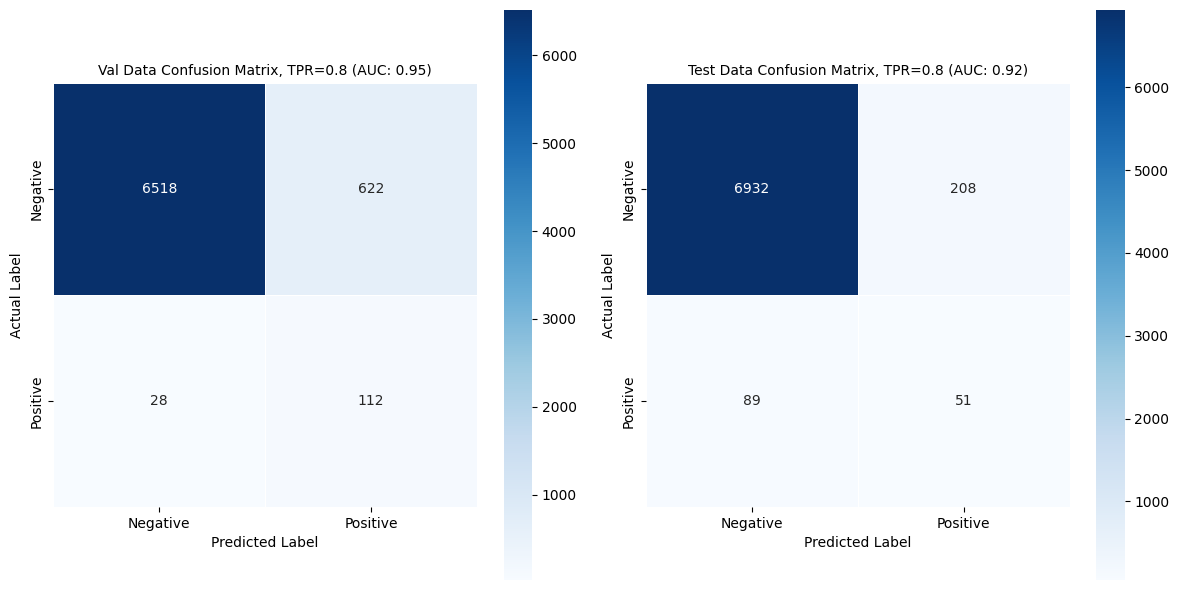

	- FPR Target: 0.05
		- Validation Accuracy: 0.9467032967032967
		- Validation Specificity: 0.9522408963585434
		- Test Accuracy: 0.9699175824175824
		- Test Specificity: 0.9831932773109243


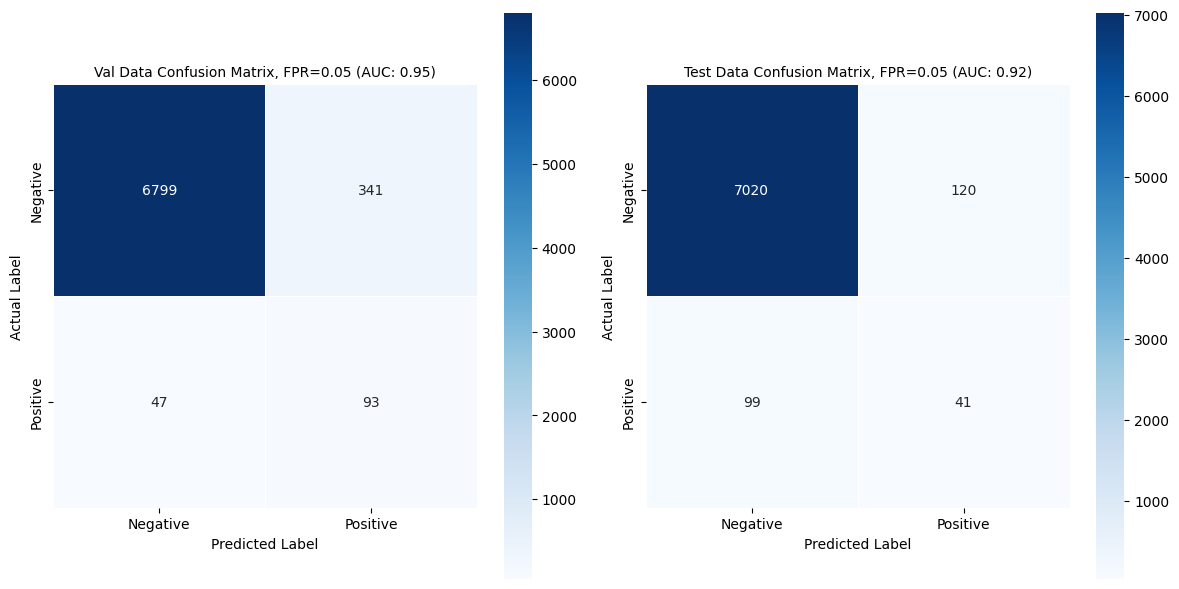

In [17]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### 4.2) RNN, 24-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [08:28<00:00,  5.09s/it]


	- Best Val AUC Epoch: 74
	- Best Val AUC: 0.8668657462985193
	- Associated Test AUC: 0.8385439175670268


	- TPR Target: 0.8
		- Validation Accuracy: 0.7899725274725274
		- Validation Recall: 0.8
		- Test Accuracy: 0.09381868131868132
		- Test Recall: 0.9857142857142858


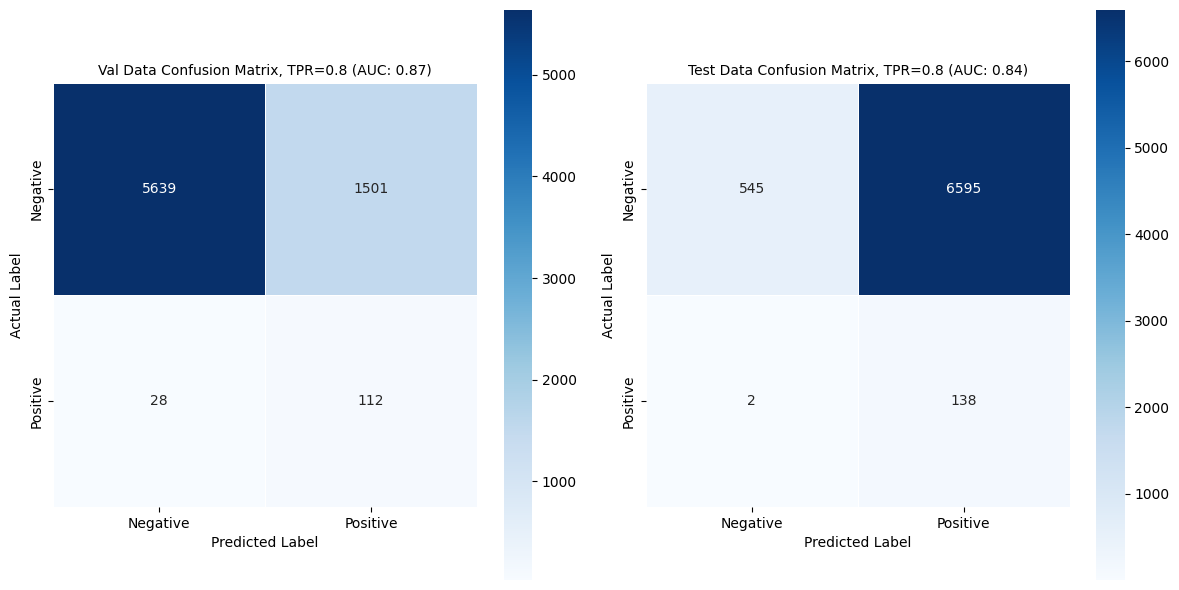

	- FPR Target: 0.05
		- Validation Accuracy: 0.9440934065934066
		- Validation Specificity: 0.95
		- Test Accuracy: 0.8962912087912088
		- Test Specificity: 0.9018207282913165


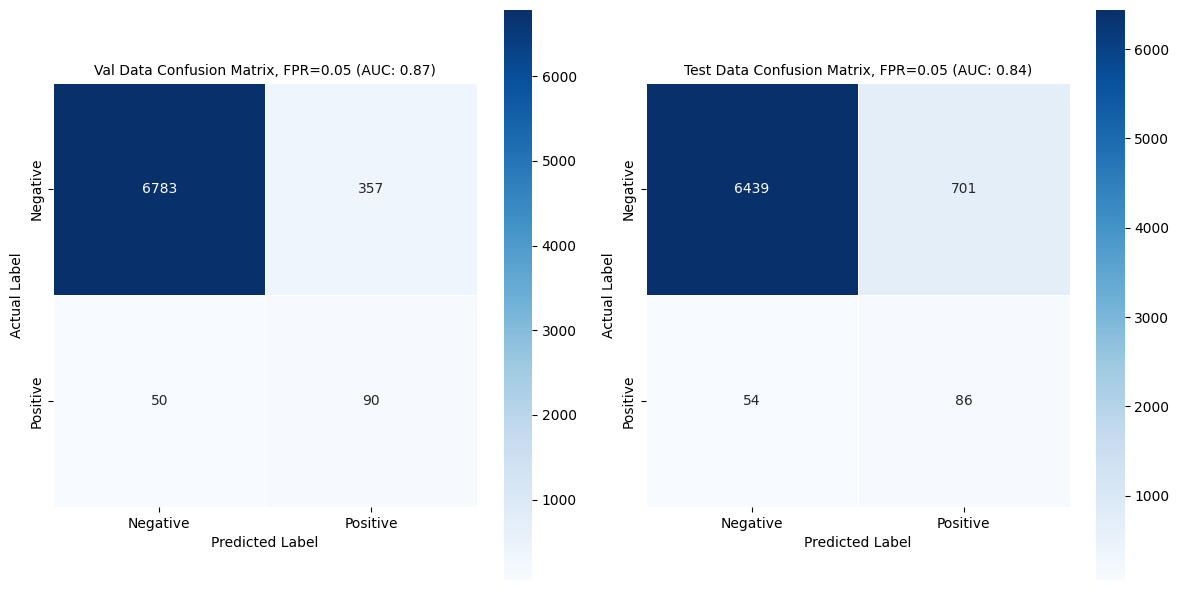

In [18]:
# get hyperparams from experiment_dict
model_type = 'rnn'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### 4.3) LSTM, 6-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [10:25<00:00,  6.25s/it]


	- Best Val AUC Epoch: 100
	- Best Val AUC: 0.9912074829931974
	- Associated Test AUC: 0.9840106042416967


	- TPR Target: 0.8
		- Validation Accuracy: 0.9884615384615385
		- Validation Recall: 0.8
		- Test Accuracy: 0.984478021978022
		- Test Recall: 0.6571428571428571


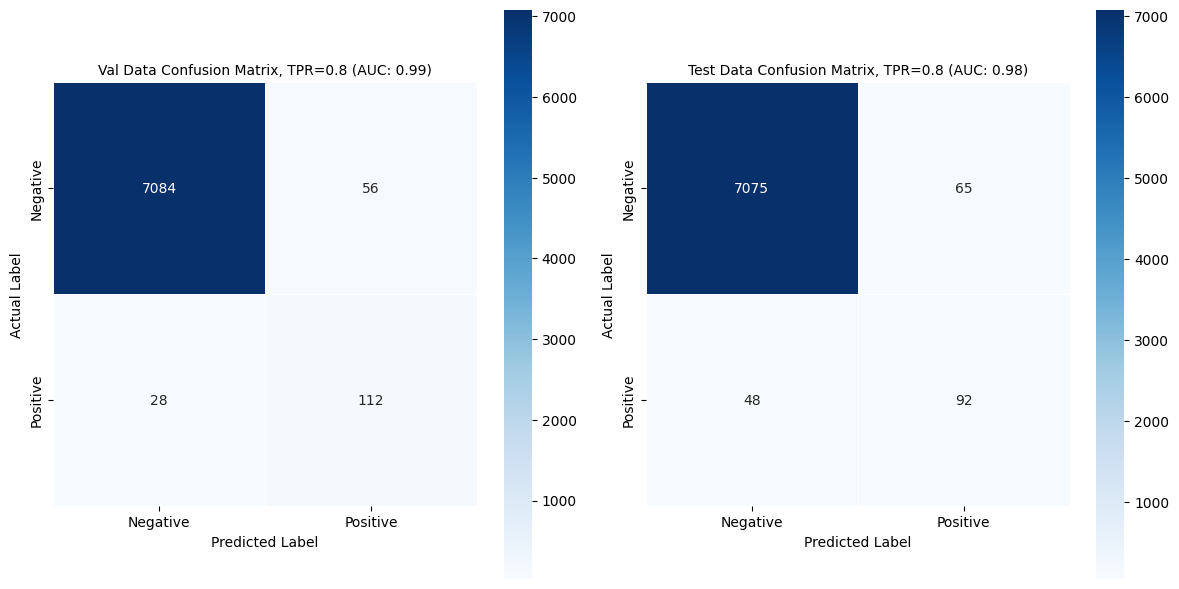

	- FPR Target: 0.05
		- Validation Accuracy: 0.942032967032967
		- Validation Specificity: 0.942156862745098
		- Test Accuracy: 0.9423076923076923
		- Test Specificity: 0.942436974789916


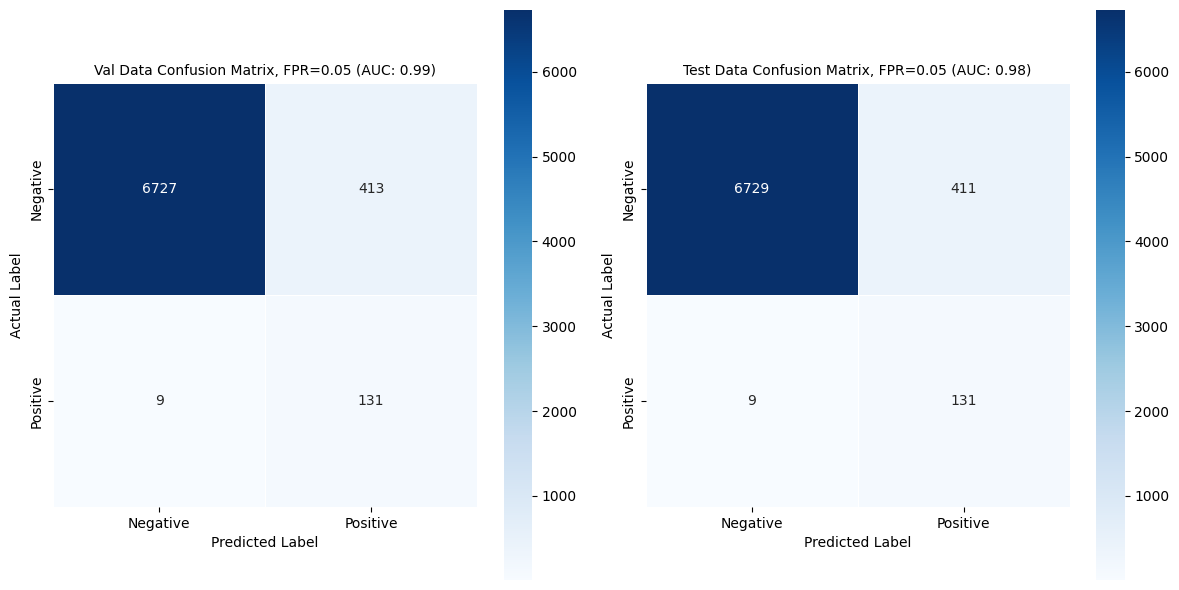

In [19]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### 4.4) LSTM, 24-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [10:44<00:00,  6.44s/it]


	- Best Val AUC Epoch: 100
	- Best Val AUC: 0.9998569427771108
	- Associated Test AUC: 0.9998469387755102


	- TPR Target: 0.8
		- Validation Accuracy: 0.9962912087912088
		- Validation Recall: 0.8071428571428572
		- Test Accuracy: 0.9967032967032967
		- Test Recall: 0.8357142857142857


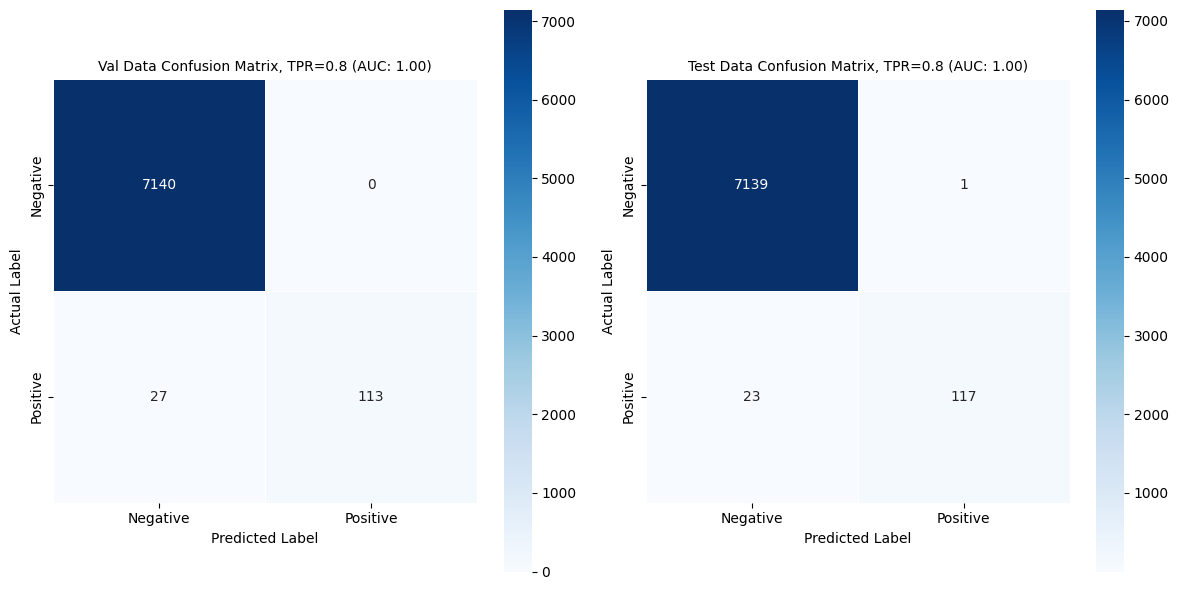

	- FPR Target: 0.05
		- Validation Accuracy: 0.9891483516483517
		- Validation Specificity: 0.9890756302521009
		- Test Accuracy: 0.9873626373626374
		- Test Specificity: 0.9871148459383754


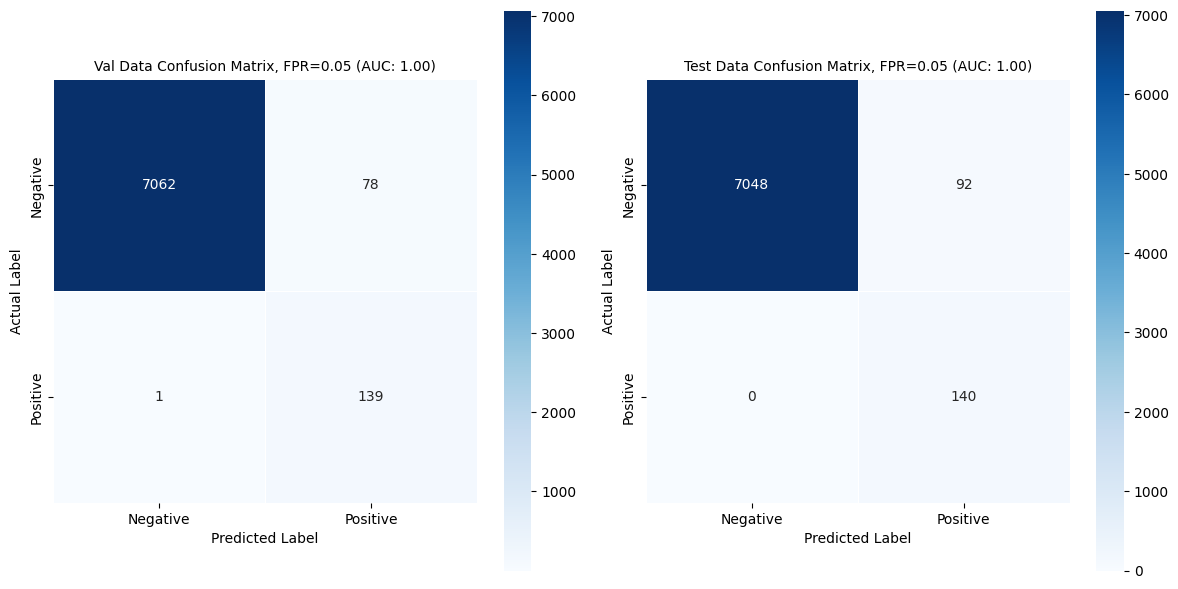

In [20]:
# get hyperparams from experiment_dict
model_type = 'lstm'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### 4.5) GRU, 6-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [20:13<00:00, 12.14s/it]


	- Best Val AUC Epoch: 62
	- Best Val AUC: 0.9999399759903962
	- Associated Test AUC: 0.9997939175670268


	- TPR Target: 0.8
		- Validation Accuracy: 0.9993131868131868
		- Validation Recall: 0.9714285714285714
		- Test Accuracy: 0.9976648351648352
		- Test Recall: 1.0


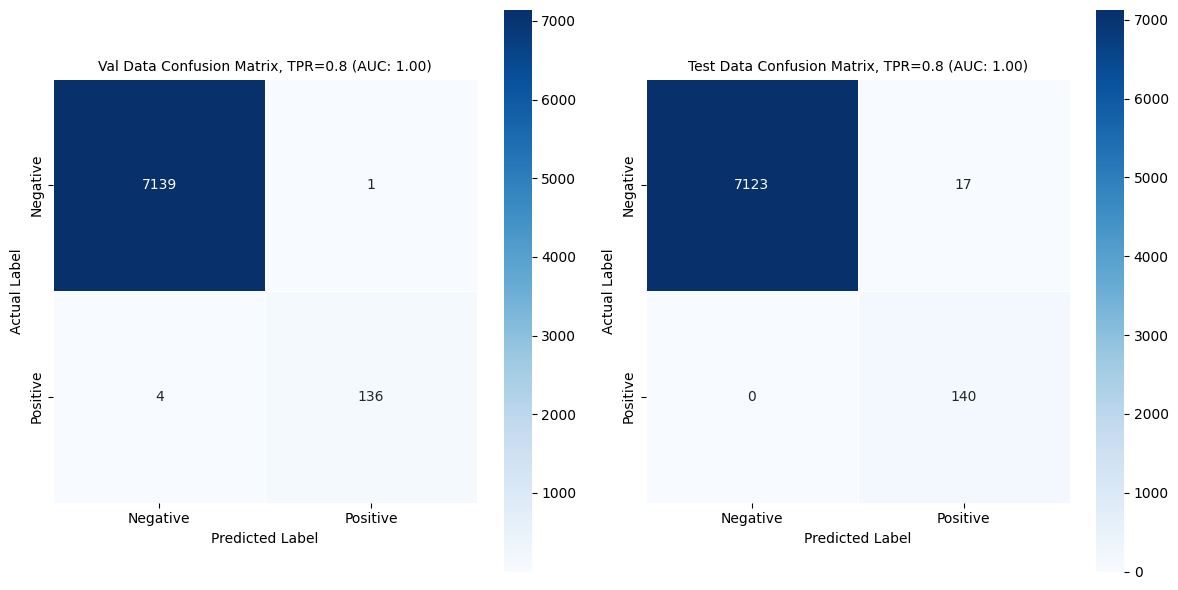

	- FPR Target: 0.05
		- Validation Accuracy: 0.9163461538461538
		- Validation Specificity: 0.9147058823529411
		- Test Accuracy: 0.8083791208791209
		- Test Specificity: 0.8046218487394958


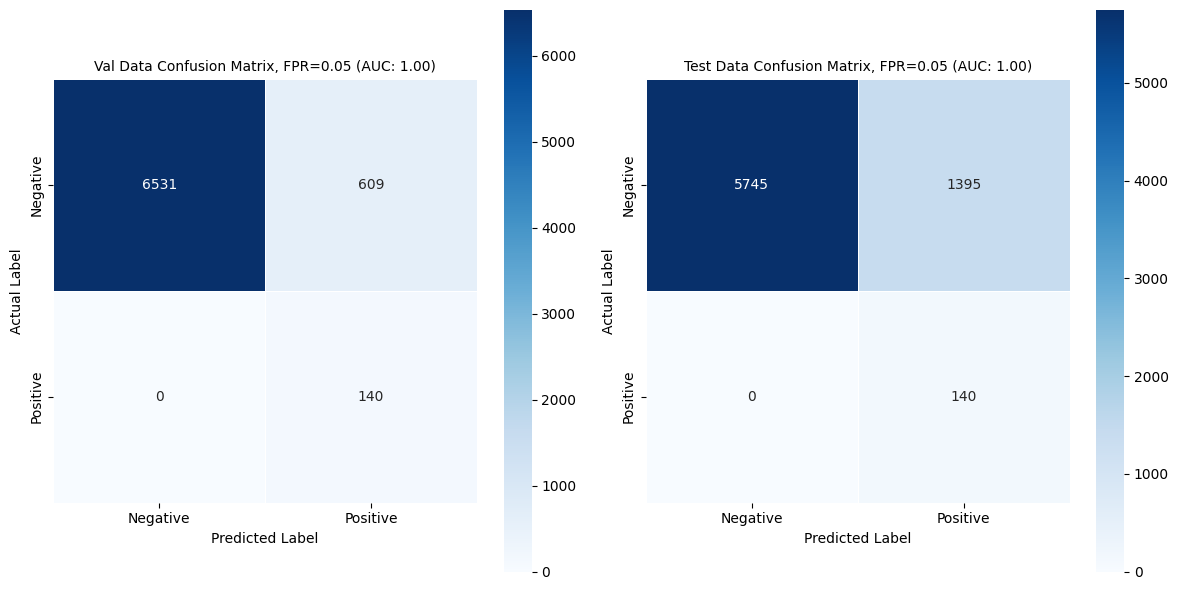

In [21]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)

##### 4.6) GRU, 24-hour failure prediction

	- 36,400 total key-value pairs in X_dict.
	- 36,400 total key-value pairs in y_dict.


Epochs: 100%|██████████| 100/100 [20:24<00:00, 12.25s/it]


	- Best Val AUC Epoch: 42
	- Best Val AUC: 0.9999869947979192
	- Associated Test AUC: 0.9998379351740696


	- TPR Target: 0.8
		- Validation Accuracy: 0.9987637362637363
		- Validation Recall: 0.9357142857142857
		- Test Accuracy: 0.9983516483516484
		- Test Recall: 0.9428571428571428


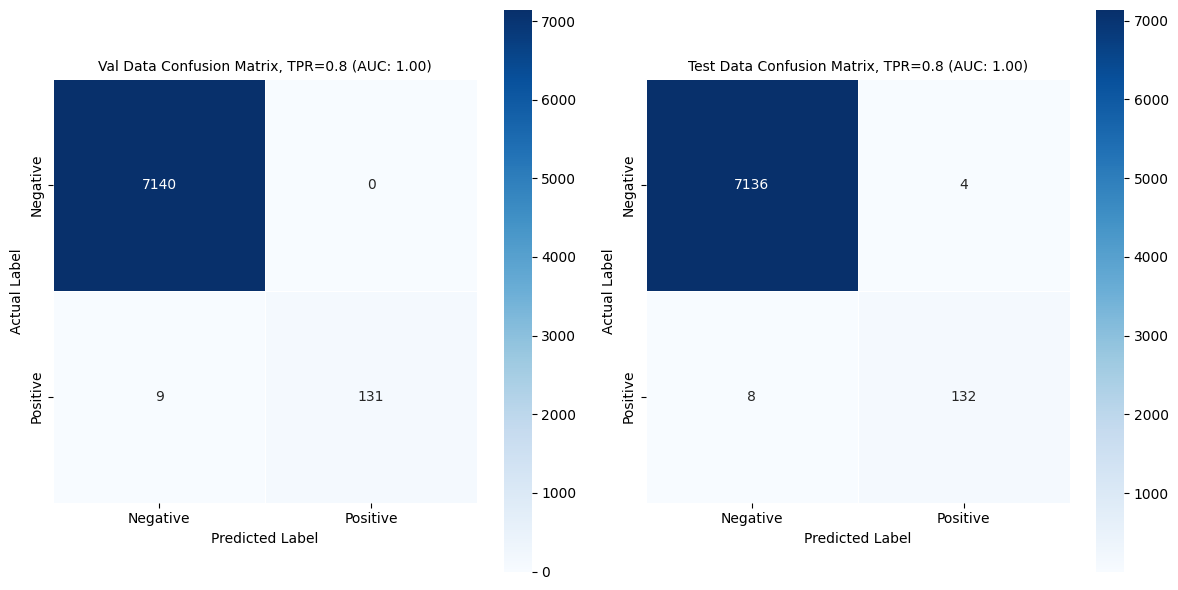

	- FPR Target: 0.05
		- Validation Accuracy: 0.9991758241758242
		- Validation Specificity: 0.9992997198879552
		- Test Accuracy: 0.9987637362637363
		- Test Specificity: 0.9990196078431373


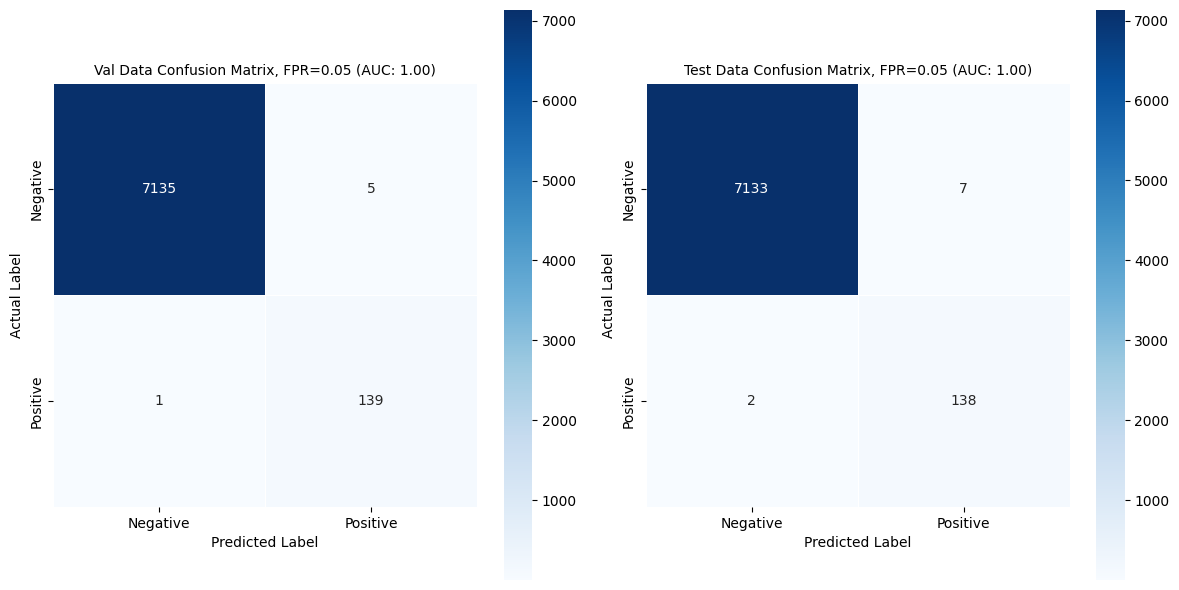

In [22]:
# get hyperparams from experiment_dict
model_type = 'gru'
features_file = 'features_data/features_dict_24hrfeaturewindow.json'
targets_file = 'targets_data/targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json'
learning_rate = 0.0005
batch_size = 64
rnn_dropout = 0.05
rnn_hidden_size = 32
rnn_num_layers = 3
classifer_mlp_dropout = 0.05
classifer_mlp_layers = [16]

weight_decay = WEIGHT_DECAY

# load feature data from file paths
X_dict = dict()
X_data_filepath = os.path.join(DATA_DIR, features_file)
with open(X_data_filepath, mode = 'r') as json_f:
    X_dict = json.load(json_f)

# load target data from file paths
y_dict = dict()
y_data_filepath = os.path.join(DATA_DIR, targets_file)
with open(y_data_filepath, mode = 'r') as json_f:
    y_dict = json.load(json_f)
# convert each value in y_dict to a list
y_dict = {
    k: [v] for k, v in y_dict.items()
}

# get overlap of keys of dictionaries
keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
X_dict = {
    k: v for k, v in X_dict.items()
    if k in keys_set
}
y_dict = {
    k: v for k, v in y_dict.items()
    if k in keys_set
}
print(f"\t- {format(len(X_dict), ',')} total key-value pairs in X_dict.")
print(f"\t- {format(len(y_dict), ',')} total key-value pairs in y_dict.")
assert len(X_dict) == len(y_dict)

# split dictionaries into train-val-test arrays
(
    X_train, X_val, X_test,
    y_train, y_val, y_test
) = get_train_val_test_arrays(
    X = X_dict,
    y = y_dict
)

# convert arrays to tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

# make Datasets
train_dataset = get_tensordataset(
    X = X_train,
    y = y_train
)
val_dataset = get_tensordataset(
    X = X_val,
    y = y_val
)
test_dataset = get_tensordataset(
    X = X_test,
    y = y_test
)

# make DataLoaders
train_loader = get_dataloader(
    dataset = train_dataset,
    shuffle = True
)
val_loader = get_dataloader(
    dataset = val_dataset,
    shuffle = False
)
test_loader = get_dataloader(
    dataset = test_dataset,
    shuffle = False
)

# instantiate classifier MLP
clasifier_mlp_input_dim = rnn_hidden_size  # size of last hidden layer of RNN
classifer_mlp = make_mlp(
    input_dim = clasifier_mlp_input_dim,
    hidden_dims = classifer_mlp_layers,
    output_dim = 1,
    dropout = classifer_mlp_dropout
)

if model_type == 'rnn':
    # instantiate RNN
    model = RNN_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'lstm':
    # instantiate LSTM
    model = LSTM_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
elif model_type == 'gru':
    # instantiate GRU
    model = GRU_Model(
        input_size = NUM_RNN_FEATURES,
        hidden_size = rnn_hidden_size,
        num_layers = rnn_num_layers,
        dropout = rnn_dropout,
        classifier_mlp = classifer_mlp
    )
else:
    raise ValueError("Please select model_type: RNN, LSTM, GRU.")

# instantiate loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# instantiate optimizer
optimizer = optim.Adam(
    params = model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)

# train-val-test
(
    best_val_auc_idx,
    best_val_y_true_list, best_val_y_hat_list,
    associated_test_y_true_list, associated_test_y_hat_list,
    train_val_test_log
) = train_validate_test(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = NUM_EPOCHS
)

# compute metrics of interest
best_val_auc = roc_auc_score(
    y_true = best_val_y_true_list,
    y_score = best_val_y_hat_list
)
associated_test_auc = roc_auc_score(
    y_true = associated_test_y_true_list,
    y_score = associated_test_y_hat_list
)

# print metrics of interest
print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
print(f"\t- Best Val AUC: {best_val_auc}")
print(f"\t- Associated Test AUC: {associated_test_auc}")
print("\n")

evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)